In [1]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
fpath = 'data/prep/'
dfile = 'form_data_v2.0.csv'

In [9]:
df = pd.read_csv( fpath + dfile, header=0, parse_dates=True )

In [10]:
# flat races
df = df[df.Type.isna()]

In [11]:
# remove entries with missing Draw - some of these could be imputed or manually entered
# print(df.RaceId[df.Draw.isna()].unique())
df = df[~df.Draw.isna()]

In [12]:
# no. declared, ie FieldSize + RR + withdrawn
DeclFieldSize = df[['RaceId', 'Draw']].groupby('RaceId').max().squeeze().rename('DeclFieldSize').astype(int)

In [13]:
df = df.join(DeclFieldSize, on='RaceId')

In [14]:
# replace non-numeric Posn with last place and cast to int TODO
# df[~df.Posn.str.isnumeric(), 'Posn'] = df[~df.Posn.str.isnumeric(), 'DeclFieldSize']
df['Posn'] = df.apply(lambda r: int(r.Posn) if r.Posn.isnumeric() else r.DeclFieldSize, axis=1)

In [16]:
new = df[df.CourseName=='Newmarket']
# new

In [17]:
yor = df[df.CourseName=='York']
# yor

In [315]:
dat = new

In [391]:
dat = yor

In [393]:
# def

In [395]:
dat = pd.DataFrame({'FieldSize': dat.DeclFieldSize, 
                    'Draw': dat.Draw.apply(int), 
                    'Index': dat.ReturnPlace+dat.ReturnWin})

In [397]:
g = dat[['FieldSize','Draw','Index']].groupby(['FieldSize','Draw'])
dat_sum = g.sum()
dat_n = g.count()

In [399]:
dat_sum = dat_sum.reset_index().pivot_table(index='FieldSize',columns='Draw').fillna(0)
dat_n = dat_n.reset_index().pivot_table(index='FieldSize',columns='Draw').fillna(0)

In [401]:
dat_sum.columns = dat_sum.columns.droplevel(0)
dat_n.columns = dat_n.columns.droplevel(0)

In [403]:
# CHK DeclFieldSize is the max index with non-zero entries each row
# (dat_n>0).apply(lambda r: np.max(r.index.values[r]), axis=1)

In [405]:
# aggregate to min ave support (default: 2)
min_ave_supp = 3

In [407]:
# TODO need to handle <min_ave_supp in general: beginning, middle, end  

In [409]:
# start from row = max draw and work backwards
# missing rows subbed by zeros beforehand

In [411]:
min_fieldsize = dat_n.index.values.min()

In [413]:
max_draw = dat_n.columns.values.max()

In [415]:
dat_0 = pd.DataFrame(np.zeros([max_draw, max_draw]), index=np.arange(1,max_draw+1), columns=np.arange(1,max_draw+1))

In [417]:
dat_sum = (dat_sum + dat_0).fillna(0)
dat_n = (dat_n  + dat_0).fillna(0) # NB. loses index name 'FieldSize'

In [419]:
# while ~np.all(dat_n.loc[min_fieldsize:,:].sum(axis=1) / dat_n.loc[min_fieldsize:,:].index.values >= min_ave_supp):
#     row_idx = dat_n.shape[0]
#     vec1_n = dat_n.loc[row_idx,:].values
#     vec1_sum = dat_sum.loc[row_idx,:].values
#     downsample = 1 / (len(vec1_n)-1) * (np.concatenate([np.diag(np.arange(len(vec1_n)-1,0,-1)), np.zeros([len(vec1_n)-1,1])], axis=1) +\
# np.concatenate([np.zeros([len(vec1_n)-1,1]), np.diag(np.arange(1,len(vec1_n),1))], axis=1))
#     vec2_n = np.matmul(downsample, vec1_n)
#     vec2_sum = np.matmul(downsample, vec1_sum)
#     dat_n.loc[row_idx-1,:row_idx-1] = dat_n.loc[row_idx-1,:row_idx-1] + vec2_n
#     dat_sum.loc[row_idx-1,:row_idx-1] = dat_sum.loc[row_idx-1,:row_idx-1] + vec2_sum
#     dat_n = dat_n.drop(row_idx, axis=0).drop(row_idx, axis=1)
#     dat_sum = dat_sum.drop(row_idx, axis=0).drop(row_idx, axis=1)
    

In [421]:
dat_n_0 = dat_n.copy()
dat_sum_0 = dat_sum.copy()

In [423]:
dat_n = dat_n_0.copy()
dat_sum = dat_sum_0.copy()
row_idx = 0

# debugger
while ~np.all(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp):
    # alternate between last and first row NEED A MORE INTELLIGENT DECISION HERE
    # row_idx = -row_idx-1
    a = dat_n.index[dat_n.sum(axis=1) / dat_n.index.values < min_ave_supp].values
    row_idx = int(sum(a < len(dat_n)/2) > len(a)/2) - 1
    # print(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp)
    # print(row_idx)
    # print()
    vec1_n = dat_n.iloc[row_idx,:dat_n.index[row_idx]].values
    vec1_sum = dat_sum.iloc[row_idx,:dat_sum.index[row_idx]].values
    if row_idx == -1:
        # downsample last
        sample_mat = 1 / (len(vec1_n)-1) * \
                        (np.concatenate( [np.diag(np.arange(len(vec1_n)-1,0,-1)), np.zeros([len(vec1_n)-1,1]) ], axis=1) + \
                        np.concatenate( [np.zeros([len(vec1_n)-1,1]), np.diag(np.arange(1,len(vec1_n),1)) ], axis=1))
        vec2_n = np.matmul(sample_mat, vec1_n)
        vec2_sum = np.matmul(sample_mat, vec1_sum)
        # add to previous
        dat_n.iloc[row_idx-1,:len(vec2_n)] = dat_n.iloc[row_idx-1,:len(vec2_n)] + vec2_n
        dat_sum.iloc[row_idx-1,:len(vec2_sum)] = dat_sum.iloc[row_idx-1,:len(vec2_sum)] + vec2_sum
        # drop last row and column
        dat_n = dat_n.drop(index=dat_n.index[row_idx]).drop(columns=dat_n.columns[row_idx])
        dat_sum = dat_sum.drop(index=dat_sum.index[row_idx]).drop(columns=dat_sum.columns[row_idx])
    else:
        # upsample first
        sample_mat = 1 / (len(vec1_n)+1) * \
                        (np.concatenate( [np.diag(np.arange(len(vec1_n),0,-1)), np.zeros([1,len(vec1_n)]) ], axis=0) + \
                        np.concatenate( [np.zeros([1,len(vec1_n)]), np.diag(np.arange(1,len(vec1_n)+1,1)) ], axis=0))
        vec2_n = np.matmul(sample_mat, vec1_n)
        vec2_sum = np.matmul(sample_mat, vec1_sum)
        # add to next
        dat_n.iloc[row_idx+1,:len(vec2_n)] = dat_n.iloc[row_idx+1,:len(vec2_n)] + vec2_n
        dat_sum.iloc[row_idx+1,:len(vec2_sum)] = dat_sum.iloc[row_idx+1,:len(vec2_sum)] + vec2_sum
        # drop first row
        dat_n = dat_n.drop(index=dat_n.index[row_idx])
        dat_sum = dat_sum.drop(index=dat_sum.index[row_idx])


In [425]:
dat_ave_np = (dat_sum / dat_n).to_numpy()
dat_n_np = dat_n.to_numpy()

In [427]:
# log-scale support (n) for annot
dat_n_np = np.round(np.log(dat_n_np+1))

In [429]:
n_draw = dat_n_np.shape[1]

In [431]:
i2 = (dat_n_np!=0).sum(axis=1)
i1 = (n_draw - i2)//2

In [433]:
hm_data = np.zeros(dat_ave_np.shape)
hm_annot = np.empty(dat_n_np.shape, dtype=str)

In [435]:
for i in range(hm_data.shape[0]):
    hm_data[ i, i1[i]:(i1[i]+i2[i]) ] = dat_ave_np[ i, :i2[i]] 
    hm_annot[ i, i1[i]:(i1[i]+i2[i]) ] = dat_n_np[ i, :i2[i]] 

In [437]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure()
plt.title('E/W Return Draw Bias, <York> (all races)')

Text(0.5, 1.0, 'E/W Return Draw Bias, <York> (all races)')

In [439]:
sns.heatmap(pd.DataFrame(
                hm_data,
                index=dat_sum.index.rename('FieldSize'),
                columns=dat_sum.columns.rename('Draw (low to high, centered)')),
            cmap='gist_earth_r', robust=True,
            annot=hm_annot, fmt='', annot_kws={'fontsize': 'xx-small'},
            xticklabels=False, yticklabels=2)
# plt.savefig('image.png')

<Axes: title={'center': 'E/W Return Draw Bias, <York> (all races)'}, xlabel='Draw (low to high, centered)', ylabel='FieldSize'>

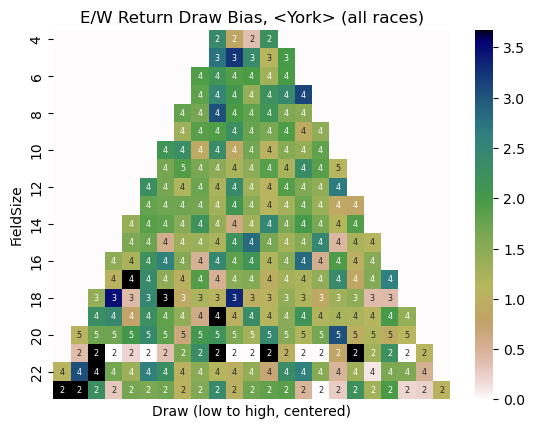

In [441]:
plt.show()